# Homework 1: Decision tree and K-nearest neighbor



This assignment is due on Canvas by **11:59pm on Friday, April 8**. 
Your solutions to theoretical questions should be done in Markdown/MathJax directly below the associated question.
Your solutions to computational questions should include any specified Python code and results 
as well as written commentary on your conclusions.
Remember that you are encouraged to discuss the problems with your instructors and classmates, 
but **you must write all code and solutions on your own**. For a refresher on the course **Collaboration Policy** click [here](https://canvas.uchicago.edu/courses/42240).

**NOTES**: 

- Do **NOT** load or use any Python packages that are not available in Anaconda with Python 3.9. 
- Some problems with code may be autograded.  If we provide a function API, **do not** change it.  If we do not provide a function API, then you're free to structure your code however you like. 
- Submit only this Jupyter notebook to Canvas.  Do not compress it using tar, rar, zip, etc. 

**Acknowledgment**: Noah Smith, Chris Ketelsen

In [2]:
import gzip
import math
import pickle
from collections.abc import Iterable

#import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score,
                             confusion_matrix)
from sklearn.model_selection import train_test_split

%matplotlib inline


### [60 points] Problem 1 - Decision tree
***

Consider the problem of predicting whether a person has a college degree based on age, salary, and Chicago residency. 
The dataset looks like the following.

| Age   | Salary         | Chicago Residency      | College degree| 
|:------:|:------------:| :-----------:|---:|
| 27 | 41,000 | Yes | Yes |
| 61 | 52,000 | No | No |
| 23 | 24,000 | Yes | No |
| 29 | 77,000 | Yes | Yes |
| 32 | 48,000 | No | Yes |
| 57 | 120,000 | Yes | Yes |
| 22 | 38,000 | Yes | Yes |
| 41 | 45,000 | Yes | No |
| 53 | 26,000 | No | No |
| 48 | 65,000 | Yes | Yes |


**Part A [5 points]**: Convert the above table to data. Two variables should be created:
        
1. $x$ is a $10*3$ matrix that contains the data from columns 0, 1, and 2. Chicago residency is represented by 1 (yes) and 0 (no).
2. $y$ contains the labels (college degree), 1 (yes) and 0 (no).

In [3]:
# YOUR CODE HERE
x = np.array(
    [
        [27, 61, 23, 29, 32, 57, 22, 41, 53, 48],
        [41000, 52000, 24000, 77000, 48000, 120000, 38000, 45000, 26000, 65000],
        [1, 0, 1, 1, 0, 1, 1, 1, 0, 1]
    ]
).T

y = np.array([1, 0, 0, 1, 1, 1, 1, 0, 0, 1])

print(x.shape)
print(y.shape)

(10, 3)
(10,)


**Part B [10 points]:** Criteria for choosing a feature to split.

**[4 points]** We start with no splitting. Assuming that our algorithm is deterministic, what is the smallest number of mistakes we can make if we do not use any of the features and what is the algorithm? (**Write your answer in the Markdown cell below.**)

Assuming that our algorithm is deterministic, without any splits we would be predicting the most common output class, which is $1$, where $1$ is a dummy indicator for having a college degree. If we use this to predict the labels on our data, we will make $4$ mistakes, because out of a total of $10$ observations, $4$ of them are $0$, and $6$ of them are $1$.

The algorithm would start at the root node, tabulate the classes in the output vector, select the most frequent and then predict all labels using the most frequent class.

**[6 points]** We start by considering the variable *Chicago residency*. The first criteria is based on the number of mistakes. We need to build a contingency table between Chicago residency and college degree.

How many mistakes will we make if we split based on Chicago residency? (**Answer below by finishing the code.**)

In [4]:
def get_error_in_leaf(y, ids):
    """
    Returns the errors in a leaf node of a decision tree.
    This function can be used to answer the previous question automatically.
    
    :@param y: all labels
    :@param ids: the subset of indexes in the leaf node
    """
    # YOUR CODE HERE
    if not isinstance(ids, Iterable):
        raise TypeError('`ids` must be an iterable')
    if not isinstance(y, np.ndarray):
        raise TypeError('`y` must be of type np.ndarray')
    
    if len(ids) == 0:
        ids = np.arange(0, len(y))
    elif len(ids) < 2:
        raise ValueError('ids must have length > 1')
        
    unique, counts = np.unique(y[ids], return_counts=True)
    errors = np.sum(y[ids] == unique[counts.argmin()])
    return errors
    

def error_criteria(y, root, left_child, right_child):
    """
    Returns the number of errors if we split the root into the left child and the right child.
    
    :@param y: all labels
    :@param root: indexes of all the data points in the root
    :@param left_child: the subset of indexes in the left child
    :@param right_child: the subset of indexes in the right child
    """
    # x = get_error_in_leaf(y, root)
    left_errors = get_error_in_leaf(y, left_child)
    right_errors = get_error_in_leaf(y, right_child)
    return left_errors + right_errors
    

def value_split_binary_feature(x, y, fid, root, criteria_func):
    
    root = root.tolist()
    left_child = [i for i in root if x[i, fid] == 0]
    right_child = [i for i in root if x[i, fid] == 1]
    return criteria_func(y, root, left_child, right_child)

# Chicago residency should correpsond to the third column in your data x
fid = 2
root = np.array(list(range(len(y)))) # root includes all data points
mistakes = value_split_binary_feature(x, y, fid, root, error_criteria)
print(mistakes)

3


In [4]:
# This cell is for grading purposes only; please ignore

**Part C [20 points]** Alternatively, we can use entropy and information gain to split the data. In this part, you will manually determine the first split in a decision tree. Please do not use code in your calculations for part C.

**[4 points]** To get familiar with MathJax, please write the equations necessary to compute entropy and information gain if we split data $D$ into $D_1$ and $D_2$. **Write your answer in the Markdown cell below.**

##### Entropy

First, to compute the entropy of data $D$:

$$H(D) = -\sum_c p_c \log_2(p_c)$$

where $p_c$ is the fraction of examples in class $c$. In the case of binary classification, that is where there are only two classes in $D$, as in $\{0, 1\} \in D$, then the entropy equation is:

$$H(D) = -p\log_2(p)-(1-p)\log_2(1-p)$$

##### Information Gain

In order to compute the information gain, which is defined as the difference between the impurity at the parent and the weighted avergae impurity of the children, that would occur from splitting $D$ into $D_1, D_2$ using feature $\phi$ we have:

$$IG(D, \phi) = H(D) - \frac{|D^\phi_1|}{|D|}H(D_1) - \frac{|D^\phi_2|}{|D|}H(D_2)$$

**[4 points]** What is the entropy for College Degree? Please show your work. Were you expecting a result around this number? Why?

The entropy for college degree is, where $\phi = \text{College Degree}$ is as follows:

$$H(\phi) = -p\log_2(p)-(1-p)\log_2(1-p)$$

Since there are 6 college graduates and 4 non-college graduates, then $p = \frac{6}{10} = 0.6$. By replacing we get:

$$H(\phi) = -(0.6)\log_2(0.6)-(1-0.6)\log_2(1-0.6)$$
$$H(\phi) = -(0.6)\log_2(0.6)-(0.4)\log_2(0.4)$$
$$H(\phi) \approx 0.442 + 0.529$$
$$H(\phi) \approx 0.971$$

I was expecting a number very close to $1$ because $H(x) = 1$ when $x$ is perfectly balanced. Since $\phi$ is not perfectly balanced, but very close to be perfectly balanced, I expected a number close to 1.

**[4 points]** What is the information gain for College Degree if you split the observations on the Chicago Residency attribute? Please show your work.

The information gain for $D$, where $D =$ `College Degree`, and where $\phi = $ `Chicago Residency`, defined by $IG(D, \phi)$ is:

$$IG(D, \phi) = H(D) - \frac{|D^\phi_{left}|}{|D|}H(D_{left}) - \frac{|D^\phi_{right}|}{|D|}H(D_{right})$$

We have the following:
- $D = (1, 0, 0, 1, 1, 1, 1, 0, 0, 1) \rightarrow |D| = 10$
- $D^\phi_{left} = (0, 1, 0) \rightarrow |D^\phi_{left}| = 3$
- $D^\phi_{right} = (1, 0, 1, 1, 1, 0, 1) \rightarrow | D^\phi_{right}| = 7$
- $H(D) = 0.971$
- $H(D^\phi_{left}) = 0.918$
- $H(D^\phi_{right}) = 0.863$

Plugging into our formula for $IG(D, \phi)$ we get:

$$IG(D, \phi) = 0.971 - \frac{3}{10}0.918 - \frac{7}{10}0.863$$
$$IG(D, \phi) = 0.971 - 0.275 - 0.604$$
$$IG(D, \phi) = 0.092$$

**[4 points]** One way to deal with continuous (or ordinal) features like Age and Salary is to define binary features based on thresholding. For example, you might convert ages to 0 if Age is less than or equal to 50 and 1 otherwise. What is the information gain for College Degree if we split the observations based on the Salary attribute with a threshold of \$50,000? Please show your work.

(Later in this problem, we will write code to determine whether a number other than \$50,000 might be the optimal threshold for Salary. For now, just assume that a threshold of \\$50,000 is optimal.)

The information gain for $D$, where $D =$ `College Degree`, and where $\phi = $ `Salary`, where $\phi = 1$ if `Salary` $>= 50000$ and $0$ otherwise:

$$IG(D, \phi) = H(D) - \frac{|D^\phi_{left}|}{|D|}H(D_{left}) - \frac{|D^\phi_{right}|}{|D|}H(D_{right})$$

We have the following:
- $D = (1, 0, 0, 1, 1, 1, 1, 0, 0, 1) \rightarrow |D| = 10$
- $D^\phi_{left} = (1, 0, 1, 1, 0, 0) \rightarrow |D^\phi_{left}| = 6$
- $D^\phi_{right} = (0, 1, 1, 1) \rightarrow | D^\phi_{right}| = 4$
- $H(D) = 0.971$
- $H(D^\phi_{left}) = 1$
- $H(D^\phi_{right}) = 0.811$

Plugging into our formula for $IG(D, \phi)$ we get:

$$IG(D, \phi) = 0.971 - \frac{6}{10}1 - \frac{4}{10}0.811$$
$$IG(D, \phi) = 0.971 - 0.6 - 0.324$$
$$IG(D, \phi) = 0.047$$

**[4 points]** Based on the information gain calculations, should the first split in our decision tree be on Chicago Residency or on Salary with a \$50,000 threshold? Is this the answer you expected based on the data counts?

Based on the information gain calculations, we should first split our decision tree on `Chicago Residency` since $IG(D, \text{Residency}) > IG(D, \text{Salary})$. No, this is not the answer I expected from the data counts!

**Part D [10 points]** Now we will write a function for computing information gain. Use log2 for entropy computation.

In [5]:
def entropy(y, ids):
    """
    Returns the entropy in the labels for the data points in ids.
    
    :@param y: all labels
    :@param ids: the indexes of data points
    """
    if len(ids) == 0: # deal with corner case when there is no data point.
        return 0
    # YOUR CODE HERE
    p = np.mean(y[ids] == 1)
    
    if p == 0 or p == 1:
        return 0
    else:
        return -p * math.log2(p) - (1 - p) * math.log2(1 - p)
    
def information_gain_criteria(y, root, left_child, right_child):
    """
    Returns the information gain by splitting root into left child and right child.
    
    :@param y: all labels
    :@param root: indexes of all the data points in the root
    :@param left_child: the subset of indexes in the left child
    :@param right_child: the subset of indexes in the right child
    """
    # YOUR CODE HERE
    root_len = len(root)
    left_len = len(left_child)
    right_len = len(right_child)
    
    wleft = left_len / root_len
    wright = right_len / root_len
    
    root_ent = entropy(y, root)
    left_ent = entropy(y, left_child)
    right_ent = entropy(y, right_child)
    
    return root_ent - wleft * left_ent - wright * right_ent
    
fid = 2
root = np.array(list(range(len(y)))) # root includes all data points
info_gain = value_split_binary_feature(x, y, fid, root, information_gain_criteria)    
print(info_gain)

0.0912774462416801


In [6]:
# This cell is for grading purposes only; please ignore

**Part E [15 points]**: Deal with continuous features.
    
**[10 points]** Complete the following code:

In [7]:
def value_split_continuous_feature(x, y, fid, root, criteria_func=information_gain_criteria):
    """
    Return the best value and its corresponding threshold by splitting based on a continuous feature.

    :@param x: all feature values
    :@param y: all labels
    :@param fid: feature id to split the tree based on
    :@param root: indexes of all the data points in the root
    :@param criteria_func: the splitting criteria function
    """
    best_value, best_thres = 0, 0
    # YOUR CODE HERE
    values = x[:, fid]
    thresholds = np.linspace(values.min(), values.max(), 25)
    
    bvals = []
    for thresh in thresholds:
        lchild = np.argwhere(values >= thresh).ravel()
        rchild = list(set(root) - set(lchild))
        bvals.append(criteria_func(y, root, lchild, rchild))
        
    bvalidx = np.argmax(bvals)
    best_value = bvals[bvalidx]
    best_thres = thresholds[bvalidx]
    
    return best_value, best_thres

root = np.array(range(len(y))) # root includes all data points
fid = 0
age_value, age_thres = value_split_continuous_feature(x, y, fid, root, information_gain_criteria)
fid = 1
salary_value, salary_thres = value_split_continuous_feature(x, y, fid, root, information_gain_criteria)

In [8]:
# This cell is for grading purposes only; please ignore

In [9]:
# This cell is for grading purposes only; please ignore

**[5 points]** Based on the current information gain by splitting different features, if we build a decision stump (decision tree with depth 1) greedily, which feature should we choose? Why? **Write down your answer in the Markdown cell below.**

Based on the current information gain by splitting different features, if we build a decisition stump greedily, the first feature we should choose is `Salary`. This is because it provides the biggest information gain out of the available features.

**Extra credit [5 points]**: You now have all the ingredients to build a decision tree recursively. You can build a decision tree of depth two and report its classification error on the training data and the tree.

In [10]:
class LeafNode:
    """
    Class for leaf nodes in the decision tree
    """
    
    def __init__(self, label, count, total):
        """
        :@param label: label of the leaf node
        :@param count: number of data points with class 'label' falling in this leaf
        :@param count: number of datapoints of any label falling in this leaf
        """
        self.label = label
        self.count = count
        self.total = total
        
    def predict(self, x):
        """
        Return predictions for features x

        :@param x: feature values
        """
        # YOUR CODE HERE
        raise NotImplementedError()
    
    def display(self, feat_names, out_str, depth=0):
        """
        Display contents of a leaf node
        """
        prefix = '\t'*depth
        error = 1.0 - self.count / float(self.total)
        out_str += f'{prefix}leaf: label={self.label}, error={error} ({self.count}/{self.total} correct)\n'
        return out_str
    
class TreeNode:
    """
    Class for internal (non-leaf) nodes in the decision tree
    """
    def __init__(self, feat_id, feat_val):
        """
        :@param feat_id: index of the feature that this node splits on
        :@param feat_val: threshold for the feature that this node splits on
        """
        self.feat_id = feat_id
        self.feat_val = feat_val
        self.left = None
        self.right = None
    
    def split(self, x, root):
        """
        Given the datapoints falling into current node, return two arrays of indices in x corresponding to the
        left and right subtree
        
        :@param x: all feature values
        :@param root: indexes of all the data points in the current node
        """
        root = np.array(root)
        # YOUR CODE HERE
        raise NotImplementedError()
    
    def predict(self, x):
        """
        Return an array of predictions for given 'x' for the current node
        
        :@param x: datapoints
        """
        assert self.left is not None and self.right is not None, 'predict called before fit'
        # YOUR CODE HERE
        raise NotImplementedError()
    
    def display(self, feat_names, out_str, depth=0):
        """
        Display contents of a non-leaf node
        """
        prefix = '\t'*depth
        out_str += f'{prefix}{feat_names[self.feat_id]}\n'
        out_str += f'{prefix}x <= {self.feat_val}\n'
        out_str = self.left.display(feat_names, out_str, depth=depth+1)
        out_str += f'{prefix}x > {self.feat_val}\n'
        out_str = self.right.display(feat_names, out_str, depth=depth+1)
        return out_str

class DecisionTree:
    """
    Class for the decision tree
    """
    def __init__(self, max_depth=1, criteria_func=information_gain_criteria, binary_feat_ids=[]):
        """
        :@param max_depth: Maximum depth that a decision tree can take
        :@param criteria_func: criteria function to split features
        :@param binary_feat_id: list of indexes of binary features
        """
        self.max_depth = max_depth
        self.criteria_func = criteria_func
        self.binary_feat_ids = binary_feat_ids
        self.root = None
        self.x = None
        self.y = None
        
    def fit(self, x, y):
        """
        Fit a tree to the given dataset using a helper function
        """
        self.x = x
        self.y = y
        self.root = self.fit_helper(np.array(list(range(self.x.shape[0]))))
    
    def fit_helper(self, root, depth=1):
        """
        Recursive helper function for fitting a decision tree
        Returns a node (can be either LeafNode or TreeNode)
        
        :@param root: array of indices of datapoints which fall into the current node
        :@param depth: current depth of the tree being built 
        """
        
        """
        Strategy:
        1. If current partition is pure i.e. labels corresponding to all indices in root are the same
           OR the maximum depth has been reached, stop building the tree and return a LeafNode
        2. If not, find out the best feature to split on along with the threshold, create a TreeNode and 
           recursively call fit_helper on the two splits (You can assume the threshold for a binary feature 
           to be 0.5). Finally, return the current node 
        """
        
        # YOUR CODE HERE
        raise NotImplementedError()
    
    def predict(self, x):
        """
        Return predictions for a given dataset  
        """
        assert self.root is not None, 'fit not yet called'
        # YOUR CODE HERE
        raise NotImplementedError()
    
    
    def display(self, feat_names):
        assert self.root is not None, 'fit not yet called'
        out_str = ""
        out_str = self.root.display(feat_names, out_str)
        return out_str

In [11]:
# This cell is for grading purposes only; please ignore
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score


### [40 points] Problem 2 - KNN for Crime Prediction 
***

In this problem, you will implement a K-Nearest Neighbors framework to predict the type of crime reported based on an incident's location.

Download [reported crime data for 2021](https://data.cityofchicago.org/Public-Safety/Crimes-2021/dwme-t96c) from the Chicago Open Data Portal (we already prepared it in the data folder, but would you to know where the source was).

**Part A [5 points]**: Load the data.  We will only use three columns of the dataset: Primary Type, Latitude, and Longitude.
- Be sure to drop any observations that are missing latitude and/or longitude.
- To reduce run time, only keep incidents reported as one of the the four most common crime types ('THEFT', 'BATTERY', 'CRIMINAL DAMAGE', 'ASSAULT'). 
- Use the train_test_split function from Scikit-Learn to split the data into training and validation sets.  Set random_state=123 and test_size=0.2.
- Finally, explore the training and validation sets and answer the following questions: 
  - How many total observations are in the training set? 
  - How many total observations are in the validation set? 

In [12]:
# Write code for answering the questions in Part A and then put your answer in the Markdown cell below.
# Make sure to set each of the variables below to the correct value. Do not rename the variables.
N_training_examples = 99749
N_validation_examples = 24938
# YOUR CODE HERE
df = pd.read_csv(
    'Crimes_-_2021.csv',
    usecols=['Primary Type', 'Latitude', 'Longitude'])

keepcats = {'THEFT', 'BATTERY', 'CRIMINAL DAMAGE', 'ASSAULT'}
df = df[df['Primary Type'].isin(keepcats)]
df.dropna(subset=['Latitude', 'Longitude'], how='any', inplace=True)

X_train, X_test, y_train, y_test = train_test_split(
    df[['Latitude', 'Longitude']].values,
    df['Primary Type'].values,
    test_size=0.2,
    random_state=123)

print(f'{len(X_train)} observations in the training set')
print(f'{len(X_test)} observations in the testing set')

99749 observations in the training set
24938 observations in the testing set


In [13]:
# This cell is for grading purposes only; please ignore

There are 99749 observations in the training set and 24938 observations in the validation set.

**Optional:**  If you'd like to run the following code chunk to render a map of the incidents, you will need to download the [neighborhood boundaries data](https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Neighborhoods/bbvz-uum9) from the Chicago Data Portal (again, we have provided a version in the data folder).

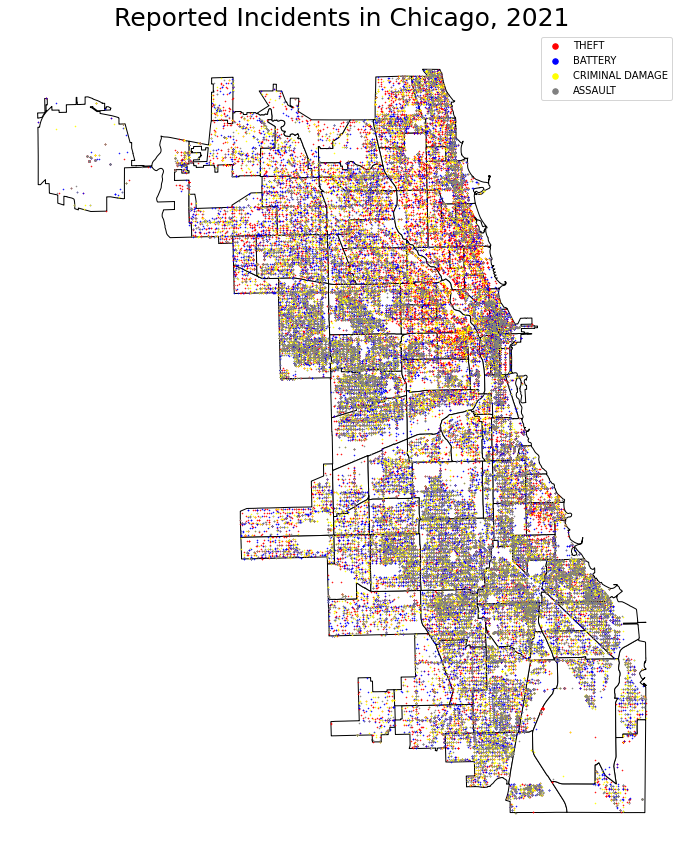

In [14]:
# Load boundaries
with open('boundaries.geojson', 'r') as file:
    boundaries = gpd.read_file(file) 

# Convert full crime dataset from pandas to geopandas
crime_gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['Longitude'], df['Latitude']),
                             crs='EPSG:4326')

# Make plot
fig, ax = plt.subplots(1, figsize=(12, 16))
boundaries.plot(ax=ax, color='white', edgecolor='black')
colors = {'THEFT' : 'red', 'BATTERY' : 'blue', 'CRIMINAL DAMAGE' : 'yellow', 'ASSAULT' : 'gray'}
grouped = crime_gdf.groupby('Primary Type', sort=True)
for key in colors:
    group = grouped.get_group(key)
    group.plot(ax=ax, label=key, color=colors[key], markersize=0.3)
ax.legend(markerscale=10)
ax.axis('off')
ax.set_title('Reported Incidents in Chicago, 2021', fontdict={'fontsize': '25', 'fontweight' : '3'});

In [15]:
class KNN:
    """
    Class to store data for regression problems 
    """
    def __init__(self, X_train, y_train, K=5, distance_weighted=False):
        """
        Creates a kNN instance

        :param X_train: Training data input in 2D ndarray 
        :param y_train: Training data output in 1D ndarray 
        :param K: The number of nearest points to consider in classification
        :param distance_weighted: Bool indicating whether to use distance weighting
        """
        
        # Import and build the BallTree on training features 
        from sklearn.neighbors import BallTree
        self.balltree = BallTree(X_train)
        
        # Cache training labels and parameter K 
        self.y_train = y_train
        self.K = K 
        
        # Boolean flag indicating whether to do distance weighting 
        self.distance_weighted = distance_weighted
        
    def majority(self, neighbor_indices, neighbor_distances=None):
        """
        Given indices of nearest neighbors in training set, return the majority label. 
        Break ties by considering 1 fewer neighbor until a clear winner is found. 

        :param neighbor_indices: The indices of the K nearest neighbors in self.X_train 
        :param neighbor_distances: Corresponding distances from query point to K nearest neighbors. 
        """
        
        # If only one neighbor, return label of that neighbor 
        if len(neighbor_indices) == 1:
            return self.y_train[neighbor_indices[0]]
        
        # If no distances provided, set to ones 
        if neighbor_distances is None:
            neighbor_distances = np.ones(len(neighbor_indices))
        
        # YOUR CODE HERE
        k_adjust = self.K
        labels, counts = np.unique(
            self.y_train[neighbor_indices[:k_adjust]],
            return_counts=True)
        while np.sum(counts == counts.max()) > 1:
            k_adjust -= 1
            labels, counts = np.unique(
                self.y_train[neighbor_indices[:k_adjust]],
                return_counts=True)
        
        rdist = np.where(neighbor_distances == 0, 1e-20, neighbor_distances)
        rdist = 1 / rdist
        
        rdist = rdist[:k_adjust]
        nbd_labels = self.y_train[neighbor_indices[:k_adjust]]
               
        top_vote = 0
        top_idx = 0
        for i, category in enumerate(labels):
            cat_total = np.sum(rdist[nbd_labels == category])
            if cat_total > top_vote:
                top_vote = cat_total
                top_idx = i
                            
        return labels[top_idx]
                    
    def classify(self, x):
        """
        Given a query point, return the predicted label 
        
        :param x: a query point stored as an ndarray  
        """
        # YOUR CODE HERE
        nhb_dists, nhb_idxs = self.balltree.query(
            x.reshape(1, -1),
            k=self.K,
            sort_results=True,
            return_distance=True)
        
        if self.distance_weighted:
            prediction = self.majority(
                neighbor_indices=nhb_idxs.ravel(),
                neighbor_distances=nhb_dists.ravel())
        else:
            prediction = self.majority(neighbor_indices=nhb_idxs.ravel())
        return prediction
        
    def predict(self, X):
        """
        Given an ndarray of query points, return yhat, an ndarray of predictions 

        :param X: an (m x p) dimension ndarray of points to predict labels for 
        """
        # YOUR CODE HERE
        results = []
        for obs in X:
            results.append(self.classify(obs))
            
        return np.array(results)

**Part B [10 points]**: Modify the class above to implement an Unweighted KNN classifier.  There are three methods that you need to complete: 

- `predict`: Given an $m \times p$ matrix of validation data with $m$ examples each with $p$ features, return a length-$m$ vector of predicted labels by calling the `classify` function on each example. 
- `classify`: Given a single query example with $p$ features, return its predicted class label as an integer using KNN by calling the `majority` function. 
- `majority`: Given an array of indices into the training set corresponding to the $K$ training examples that are nearest to the query point, return the majority label as an integer.  If there is a tie for the majority label using $K$ nearest neighbors, reduce $K$ by 1 and try again.  Continue reducing $K$ until there is a winning label. 

**Notes**: 
- Don't even think about implementing nearest-neighbor search or any distance metrics yourself.  Instead, go read the documentation for Scikit-Learn's [BallTree](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.BallTree.html) object.  You will find that its implemented [query](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.BallTree.html#sklearn.neighbors.BallTree.query) method can do most of the heavy lifting for you. 
- **Do not** use Scikit-Learn's KNeighborsClassifier in this problem.  We're implementing this ourselves. 
- You don't need to worry about the `distance_weighted` flag until **Part C**, but we recommend reading ahead a bit. It might be good to think about your implementation of **Part C** before implementing **Part B**. 
- When you think you're done, execute the following cell to run 4 unit tests based on the example starting on Slide 15 of the KNN Lecture slides on Canvas.

In [16]:
from tests import tests
tests.run_test_suite('prob 2A', KNN)

test1NNclassify (tests.tests.TestUnweightedKNN)
test 1NN ... ok
test2NNclassify (tests.tests.TestUnweightedKNN)
test 2NN. Checks tie-breaking. ... ok
test3NNclassify (tests.tests.TestUnweightedKNN)
test 3NN ... ok
test3NNpredict (tests.tests.TestUnweightedKNN)
test 3NN prediction ... ok

----------------------------------------------------------------------
Ran 4 tests in 0.006s

OK


**Part C [5 points]**: Modify the `KNN` class to perform the distance-weighted KNN classification.
The so-called Distance-Weighted KNN classifier assigns weights to the nearest-neighbor training examples proportional to the inverse-distance from the training example to the query point.  Classification is performed by summing the weights associated with each class and predicting the class with the highest weighted-majority vote.  Mathematically we might describe the weighted-vote for a class $c$ as 

$$
\textrm{Weighted-Vote}(c) = \displaystyle\sum_{i \in {\cal N}_K} I(y_i = c) \times \dfrac{1}{\|{\bf x}_i - {\bf x}\|}
$$

A word of caution: it's certainly possible that a query point could be distance $0$ away from some training example.  If this happens your implementation should handle it gracefully and return the appropriate class label.   

When you think you're done, execute the following cell to run three final unit tests corresponding to the example on Slide 21 of the KNN Lecture slides on Canvas. Make sure that the changes you make in **Part C** do not affect the unit tests from **Part B**.   


In [17]:
from tests import tests
tests.run_test_suite('prob 2B', KNN)

test5NNclassify (tests.tests.TestWeightedKNN)
test 5NN ... ok
test3NNclassify (tests.tests.TestWeightedKNN)
test 3NN. Checks divide-by-zero issue. ... ok
test5NNpredict (tests.tests.TestWeightedKNN)
test 5NN prediction ... ok

----------------------------------------------------------------------
Ran 3 tests in 0.004s

OK


**Part D [8 points]**: Use your `KNN` class to perform weighted KNN on the validation data with $K=100$ and do the following: 

- **[4 points]** Create a **confusion matrix** (feel free to use the Scikit-Learn [confusion_matrix](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) function).  


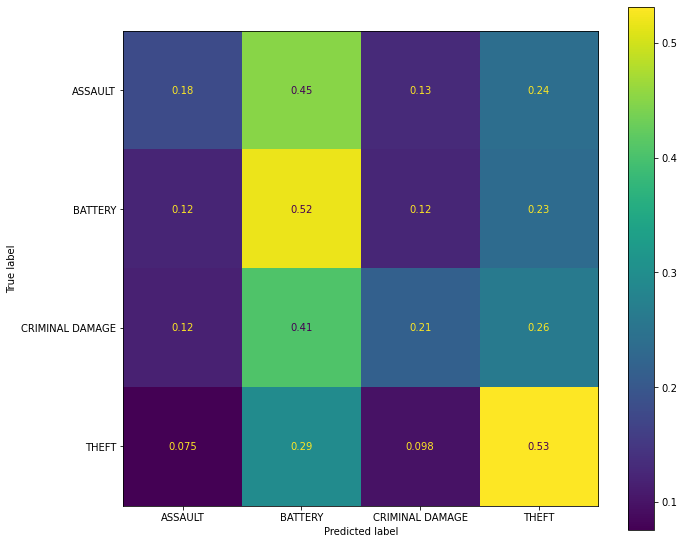

In [18]:
knn = KNN(X_train, y_train, K=100, distance_weighted=True)
yhat_valid = knn.predict(X_test)
# YOUR CODE HERE
labels = np.unique(y_test).tolist()
cm = confusion_matrix(
    y_true=y_test,
    y_pred=yhat_valid,
    normalize='true')
disp = ConfusionMatrixDisplay(cm, display_labels=labels)
disp.plot()
disp.figure_.set_size_inches(10, 8)
disp.figure_.tight_layout()

- **[4 points]** Based on your confusion matrix, which crime types are most frequently misclassified as other crime types? 

Based on our confusion matrix, which is normalized within each row, that is for each true prediction, the shares indicate what share of each class is predicted across the row.

Then for each category the most frequent misclassified crimes are:
- `ASSAULT`: 45% misclassified as `BATTERY`
- `BATTERY`: 23% misclassified as `THEFT`
- `CRIMINAL DAMAGE`: 41% misclassified as `BATTERY`
- `THEFT`: 29% misclassified as `BATTERY`

**Part E [12 points]**: **[4 points]** Create a plot of the accuracy of both Unweighted and Distance-Weighted KNN on the validation set on the same set of axes for various values of $K$. Your plot should show the approximate value of $K$ that maximizes the accuracy. Note that accuracy will be below 50%, but above 25% (i.e., better than random classification).

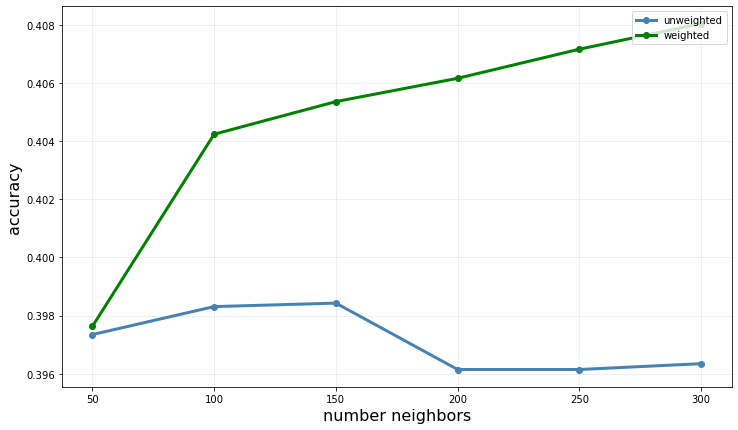

In [19]:
acc = []
wacc = []
allks = [50, 100, 150, 200, 250, 300]

# YOUR CODE HERE
for k_val in allks:
    knn = KNN(X_train, y_train, K=k_val, distance_weighted=False)
    yhat_valid = knn.predict(X_test)
    acc.append(accuracy_score(y_true=y_test, y_pred=yhat_valid))
    
    knn = KNN(X_train, y_train, K=k_val, distance_weighted=True)
    yhat_valid = knn.predict(X_test)
    wacc.append(accuracy_score(y_true=y_test, y_pred=yhat_valid))
    
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12, 7))
ax.plot(allks, acc, marker="o", color="steelblue", lw=3, label="unweighted")
ax.plot(allks, wacc, marker="o", color="green", lw=3, label="weighted")
ax.set_xlabel("number neighbors", fontsize=16)
ax.set_ylabel("accuracy", fontsize=16)
ax.legend(loc="upper right")
plt.xticks(range(50, 301, 50))
ax.grid(alpha=0.25)

**[4 points]** Based on the plot, answer the following questions: 

- For general $K$, does Unweighted or Weighted KNN appear to perform better? 
- Which value of $K$ attains the best accuracy on the validation set? 

Open questions: Why do you think this is the case? How can you explain this?

- For general $K$, the Weighted KNN classifier performs better.
- The value of $K$ which maximizes the accuracy for the Weighted KNN classifier is $K = 300$

I think the Weighted KNN performs better because we are using physical coordinates on the surface of the planet. Specifically within a city, where hundreds of a degree variation can be the difference between something that happened in a park, and something that happened within a household. Therefore small changes in distance can mean a lot.

Thinking that the geo-coordinate of a crime tells us something about the crime directly, i.e. somebody thinks "Oh, I am at exactly 37.2494 degrees south, time to commit BATTERY" is misleading. Instead we should think that the coordinates tells us something about location, and location is what gives us information about the type of crime. For example some crimes are more likely to happen in parks, while others are more likely to happen at bars, or concerts, households, etc. This is exactly why weighting works better, because with the weighting we can distinguish between a bar and a footbal stadium.

**[4 points]** If you had unrestricted access to data, how might you improve the model to try to increase classification accuracy?

If I had unrestricted access to data, I would improve the model by adding as much information about the crime as possible.

If we think that individuals choose to commit crime following a hedonic model that incorporates context. We can't know exactly what the true function for an individual is, but we can approximate it. We can think of a couple of things that might affect the probability of the crime being either of the classes: time of day, race of offender, race of victim, income of offender, income of victim, gender of offender, gender of victim, time of the year, weather, minimum distance to a bar, etc. I would add all these variables as additional features, to mitigate misclassification.

Also it seems that crimes occur together, that is one instance of a crime could have many labels at the same time, if this is the case, then we would have to model the probability that a subset of the labels happens jointly. This might help a lot with misclassification, because it seems that `THEFT` happens frequently close with `BATTERY`.